# DEM elevation extraction - work in progress

The script assumes that you have downloaded the data of AOI 1 (query_download_icesat2.ipynb) and installed the srtm package (srtm.ipynb).

In [116]:
import srtm
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import hvplot.pandas # Enable 'hvplot' accessor on Geodataframes for interactive plotting
import rasterio
import xarray as xr
import hvplot.xarray
import geopandas as gpd
import rioxarray
%matplotlib inline

In [117]:
 # adapted from tutorial "Data integration .. Part I"

# Load some ICESat-2 data, for now we load one track, one beam (GT2R/L)
data_path = '/home/jovyan/data/'
is2_file = 'processed_ATL08_20210309165425_11561006_005_01.h5' # there should be some snow in March..?
with h5py.File(data_path+is2_file, 'r') as f:
    is2_gt2r = pd.DataFrame(data={'lat': f['gt2r/land_segments/latitude'][:],
                                  'lon': f['gt2r/land_segments/longitude'][:],
                                  'h_te_best_fit': f['gt2r/land_segments/terrain/h_te_best_fit'][:]})
    is2_gt2l = pd.DataFrame(data={'lat': f['gt2l/land_segments/latitude'][:],
                                 'lon': f['gt2l/land_segments/longitude'][:],
                                  'h_te_best_fit': f['gt2l/land_segments/terrain/h_te_best_fit'][:]})

In [118]:
# select onoe of the beams and convert it to a geodataframe
gf = gpd.GeoDataFrame(is2_gt2l, geometry=gpd.points_from_xy(is2_gt2l.lon, is2_gt2l.lat), crs='epsg:7661')
gf.head()

,lat,lon,h_te_best_fit,geometry
0,39.114582,-108.160164,1991.638184,POINT (-108.16016 39.11458)
1,39.113682,-108.160278,1990.215820,POINT (-108.16028 39.11368)
2,39.112785,-108.160385,1993.566284,POINT (-108.16039 39.11279)
3,39.111885,-108.160500,2006.203735,POINT (-108.16050 39.11189)
4,39.110989,-108.160606,2012.116333,POINT (-108.16061 39.11099)


**TO DO** - More elegant way as in geospatial tutorial: how to read ATL08 ICESat-2 files as in-memory file-like objects using xarray

In [119]:
# for ATL08, this doesn't include any heights, as these are in the group 'gt2r/land_segments/terrain'!
#ds = xr.open_dataset(is2_file, group='gt2l/land_segments')
# inspect the data for beam group
#ds

# For simplicity take first 1000 points into a Geopandas Geodataframe
#df = ds.isel(delta_time=slice(0,1000)).to_dataframe()

# NOTE: that the CRS is not propagated by xarray from the HDF5 metadata, so we have to assign it again!
#gf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='epsg:7661')
#gf.head()

In [120]:
# plot in a neat map - geospatial tutorial 
gf.hvplot.points(c='h_te_best_fit', coastline=True, tiles=True, cmap='viridis', data_aspect=0.1)

:Overlay
   .Tiles.I     :Tiles   [x,y]
   .Points.I    :Points   [Longitude,Latitude]   (h_te_best_fit)
   .Coastline.I :Feature   [Longitude,Latitude]

# DEM extraction
1. SRTM via srtm.py

In [ ]:
# get the DEM for the area 
geo_elevation_data = srtm.get_data(srtm1=True, local_cache_dir='/home/jovyan/data/srtm/')

image_size = 500

#bounding box for the AOI_1
latitude_interval = (38.884619201291905, 39.11727568585598)
longitude_interval= (-108.24005126953124, -107.9)

# get data - ideally: 30m resolution, some form of a geodataset, doesn't need to be loaded
dem_file = geo_elevation_data.get_image(np.mean(latitude_interval), np.mean(longitude_interval))


**that does not yet work... Fixing needed!**

2. SRTM via GEE - TO DO

In [122]:
#dem_ds = rasterio.open(dem_file)

# 3. Copernicus DEM

In [139]:
CopDEM = rioxarray.open_rasterio('https://opentopography.s3.sdsc.edu/raster/COP30/COP30_hh.vrt', 
                              chunks=True, # ensure we use dask to only read metadata
                             )

# Crop by Bounding box of all the ATL08 points
minx, miny, maxx, maxy = gf.unary_union.envelope.bounds # got a depreciation warning with cascaded_union
CopDEM = CopDEM.rio.clip_box(minx, miny, maxx, maxy)
CopDEM

<xarray.DataArray (band: 1, y: 728, x: 90)>
dask.array<copy, shape=(1, 728, 90), dtype=float32, chunksize=(1, 728, 90), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -108.2 -108.2 -108.2 ... -108.2 -108.2 -108.2
  * y            (y) float64 39.11 39.11 39.11 39.11 ... 38.91 38.91 38.91 38.91
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [140]:
# enable hvplot accessor on xarray datasets
CopDEM.squeeze('band').hvplot.image(rasterize=True, cmap='viridis', title='Copernicus 30m DEM')

:DynamicMap   []
   :Image   [x,y]   (value)

In [125]:
# reproject the DEM - maybe not needed, to avoid adding error due to resampling etc?

In [141]:
# create a coordinate array for ATL08 samples 
coords = [(x,y) for x, y in zip(gf.geometry.x, gf.geometry.y)]
# for a pandas dataframe without geometry, one can use columns instead: 
# coords = [(x,y) for x, y in zip(df.lat, df.lon)]

**Fixing needed below to avoid save-to-disk workaround..?**

In [142]:
# sample using the rasterio sample method: Preparations
# rasterio.sample complains when it gets fed a data array opened by rioxarray. 
# Currently solved with an ugly detour via saving to disk. Needs FIXING!!

CopDEMfolder = '/home/jovyan/data/CopDEM/'
!mkdir CopDEMfolder
dempath = CopDEMfolder+'CopDEM_'+is2_file[:-3]+'.tif'
print(dempath)
CopDEM.rio.to_raster(dempath)
CopDEMrasterio  = rasterio.open(dempath)

# Rasterio can read from the same source, i.e. the first line below works:
# CopDEM= rasterio.open('https://opentopography.s3.sdsc.edu/raster/COP30/COP30_hh.vrt', chunks=True)
# but clipping the DEM to our aoi seems much more complicated - not yet attempted, though:
# https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html 
#gf['CopDEMh'] =np.array([x[0] for x in rasterio.sample.sample_gen(CopDEM,coords)],)# create a coordinate array for ATL08 samples 

# the geospatial tutorial, gdal is used to save the file to disk. Maybe faster..? 
#ulx, lry, lrx, uly = gf.unary_union.envelope.bounds
#print('lower right', lrx, lry)
#print('upper left', ulx, uly)

# Save vertically shifted subset locally
#infile = '/vsicurl/https://opentopography.s3.sdsc.edu/raster/COP30/COP30_hh.vrt'

#!GDAL_DISABLE_READDIR_ON_OPEN=EMPTY_DIR gdal_translate -projwin {ulx} {uly} {lrx} {lry} {infile} {dempath}


mkdir: cannot create directory ‘CopDEMfolder’: File exists
/home/jovyan/data/CopDEM/CopDEM_processed_ATL08_20210309165425_11561006_005_01.tif


In [143]:
# sample using the rasterio sample method
gf['demH'] =np.array([x[0] for x in CopDEMrasterio.sample(coords)],)
gf.head()

,lat,lon,h_te_best_fit,geometry,demH,demH_WGS84
0,39.114582,-108.160164,1991.638184,POINT (-108.16016 39.11458),2005.553467,0.0
1,39.113682,-108.160278,1990.215820,POINT (-108.16028 39.11368),2008.514893,0.0
2,39.112785,-108.160385,1993.566284,POINT (-108.16039 39.11279),2012.100830,0.0
3,39.111885,-108.160500,2006.203735,POINT (-108.16050 39.11189),2021.313843,0.0
4,39.110989,-108.160606,2012.116333,POINT (-108.16061 39.11099),2029.781982,0.0


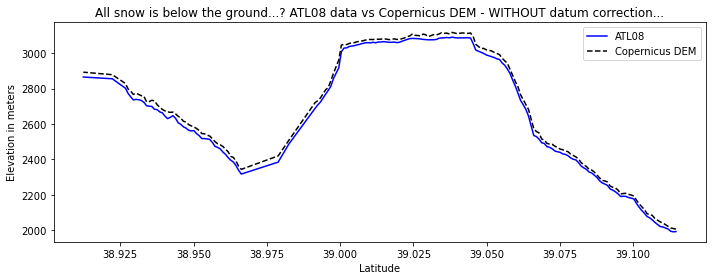

In [144]:
# a profile plot:
# create the figure and axis
fig, ax = plt.subplots(figsize=[10,4])
# add atl08 data
atl08, = ax.plot(gf.geometry.y, gf.h_te_best_fit, label='ATL08', linestyle='-', color='blue')
CopDEM, = ax.plot(gf.geometry.y, gf.demH, label='Copernicus DEM', linestyle='--',color='black')
ax.set_xlabel('Latitude')
ax.set_ylabel('Elevation in meters')
ax.set_title('All snow is below the ground...? ATL08 data vs Copernicus DEM - WITHOUT datum correction...')
ax.legend()
fig.tight_layout()

**To do: add ATL03, ATL06 data, e.g. with data_collator from the vizualisation tutorial?**

# Adjust vertical reference system

In [ ]:
# Problem: the two datasets don't have the same vertical reference. 
# Follow the gdal steps on the geospatial tutorial 
# to convert the CopDEM from EGM2008 geoid heights to WGS84 ellipsoid heights.

# we already saved the raster to disc and can take that one directly: 
outfile = dempath[:-4]+'_WGS84.tif'
!CPL_DEBUG=ON PROJ_DEBUG=2 gdalwarp -s_srs EPSG:4326+3855 -t_srs EPSG:7661 $dempath $outfile


In [147]:
# OK, that did something, now we have to redo the coordinate sampling with the new DEM file: 
CopDEMWGS84  = rasterio.open(outfile)
gf['demH_WGS84'] =np.array([x[0] for x in CopDEMWGS84.sample(coords)],)
gf.head()

,lat,lon,h_te_best_fit,geometry,demH,demH_WGS84
0,39.114582,-108.160164,1991.638184,POINT (-108.16016 39.11458),2005.553467,1989.396484
1,39.113682,-108.160278,1990.215820,POINT (-108.16028 39.11368),2008.514893,1992.359375
2,39.112785,-108.160385,1993.566284,POINT (-108.16039 39.11279),2012.100830,1995.947632
3,39.111885,-108.160500,2006.203735,POINT (-108.16050 39.11189),2021.313843,2005.162964
4,39.110989,-108.160606,2012.116333,POINT (-108.16061 39.11099),2029.781982,2013.632690


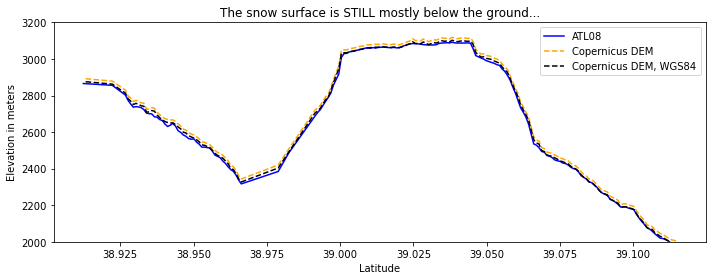

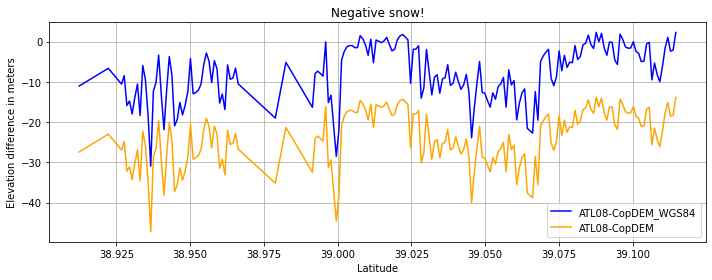

In [148]:
# seems we lost some data in the start of our profile...? well, ignore for now... 

# re-create the plot:
fig, ax = plt.subplots(figsize=[10,4])
# add atl08 data
atl08, = ax.plot(gf.geometry.y, gf.h_te_best_fit, label='ATL08', linestyle='-', color='blue')
CopDEM, = ax.plot(gf.geometry.y, gf.demH, label='Copernicus DEM', linestyle='--',color='orange')
CopDEMWGS84, = ax.plot(gf.geometry.y, gf.demH_WGS84, label='Copernicus DEM, WGS84', 
                       linestyle='--',color='black')
ax.set_xlabel('Latitude')
ax.set_ylabel('Elevation in meters')
ax.set_title('The snow surface is STILL mostly below the ground...')
ax.legend()
ax.set_ylim((2000,3200))
fig.tight_layout()

# difference plot:
fig, ax = plt.subplots(figsize=[10,4])
snowdepth, = ax.plot(gf.geometry.y, gf.h_te_best_fit-gf.demH_WGS84, label='ATL08-CopDEM_WGS84', linestyle='-', color='blue')
snowdepth_uncorrected, = ax.plot(gf.geometry.y, gf.h_te_best_fit-gf.demH, label='ATL08-CopDEM', linestyle='-', color='orange')
ax.set_xlabel('Latitude')
ax.set_ylabel('Elevation difference in meters')
ax.set_title('Negative snow!')
ax.legend()
ax.grid()
#ax.set_ylim((-50,10))
fig.tight_layout()

# Ideas how to continue:
1. co-register 
2. vertical shift correction using elevations from snow-off tracks in the area